In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

c:\Users\samir\anaconda3\envs\ml_cnn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Téléchargement et prétraitement des données

In [2]:
# Définition de constantes et d'hyperparamètres
BUFFER_SIZE = 70_000 
BATCH_SIZE = 128
NUM_EPOCHS = 20

In [3]:
# Téléchargement de l'ensemble de données MNIST
# Lorsque 'with_info' est défini sur True, tfds.load() renvoie deux variables :
# - l'ensemble de données (y compris les ensembles d'entraînement et de test)
# - des informations métadonnées concernant l'ensemble de données lui-même

mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

In [4]:
# Extraction de l'ensemble d'entraînement et de test
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

In [5]:
# Création d'une fonction pour scaler les images
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.

    return image, label

In [6]:
# Mise à l'échelle des données
train_and_validation_data = mnist_train.map(scale)
test_data = mnist_test.map(scale)

In [7]:
# Definiton de la taille de l'ensemble de validation
num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

In [8]:
# Definiton de la taille de l'ensemble de test
num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)

In [9]:
# Reshuffling des données
train_and_validation_data = train_and_validation_data.shuffle(BUFFER_SIZE)

In [10]:
# Séparation des données d'entraînement et de validation
train_data = train_and_validation_data.skip(num_validation_samples)
validation_data = train_and_validation_data.take(num_validation_samples)

In [11]:
# Batching des données
train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples) 
test_data = test_data.batch(num_test_samples)

## Création du modèle et entraînement

In [12]:
# Construction du modèle
# CONV -> MAXPOOL -> CONV -> MAXPOOL -> FLATTEN -> DENSE
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(50, 5, activation='relu', input_shape=(28, 28, 1)), #
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Conv2D(50, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10) 
])

In [13]:
# Résumé du modèle
model.summary(line_length = 75)

Model: "sequential"
___________________________________________________________________________
 Layer (type)                    Output Shape                  Param #     
 conv2d (Conv2D)                 (None, 24, 24, 50)            1300        
                                                                           
 max_pooling2d (MaxPooling2D)    (None, 12, 12, 50)            0           
                                                                           
 conv2d_1 (Conv2D)               (None, 10, 10, 50)            22550       
                                                                           
 max_pooling2d_1 (MaxPooling2D)  (None, 5, 5, 50)              0           
                                                                           
 flatten (Flatten)               (None, 1250)                  0           
                                                                           
 dense (Dense)                   (None, 10)                    12510

In [15]:
# Definiton de la fonction de perte
# En général, notre modèle doit produire les probabilités de chaque classe,
# ce qui peut être réalisé avec une activation softmax dans la dernière couche.

# Cependant, lors de l'utilisation de l'activation softmax, la perte peut parfois être instable.

# Ainsi, au lieu d'intégrer le softmax directement dans le modèle,
# nous utilisons un calcul de perte qui corrige automatiquement l'absence du softmax.

# C'est la raison pour laquelle on utilise 'from_logits=True'.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [16]:
# Compilation du modèle avec l'optimiseur Adam et la fonction de perte définie ci-dessus
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [17]:
# Definiton de la fonction de rappel pour l'arrêt anticipé
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',    
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [18]:
# Entraînement du modèle
model.fit(
    train_data, 
    epochs = NUM_EPOCHS, 
    callbacks = [early_stopping], 
    validation_data = validation_data,
    verbose = 2
)

Epoch 1/20
422/422 - 28s - loss: 0.2625 - accuracy: 0.9286 - val_loss: 0.0800 - val_accuracy: 0.9763 - 28s/epoch - 66ms/step
Epoch 2/20
422/422 - 28s - loss: 0.0707 - accuracy: 0.9783 - val_loss: 0.0622 - val_accuracy: 0.9813 - 28s/epoch - 66ms/step
Epoch 3/20
422/422 - 28s - loss: 0.0530 - accuracy: 0.9841 - val_loss: 0.0388 - val_accuracy: 0.9867 - 28s/epoch - 66ms/step
Epoch 4/20
422/422 - 30s - loss: 0.0441 - accuracy: 0.9862 - val_loss: 0.0371 - val_accuracy: 0.9888 - 30s/epoch - 70ms/step
Epoch 5/20
422/422 - 29s - loss: 0.0377 - accuracy: 0.9884 - val_loss: 0.0358 - val_accuracy: 0.9900 - 29s/epoch - 68ms/step
Epoch 6/20
422/422 - 28s - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0241 - val_accuracy: 0.9927 - 28s/epoch - 67ms/step
Epoch 7/20
422/422 - 29s - loss: 0.0277 - accuracy: 0.9910 - val_loss: 0.0213 - val_accuracy: 0.9928 - 29s/epoch - 68ms/step
Epoch 8/20
422/422 - 29s - loss: 0.0241 - accuracy: 0.9924 - val_loss: 0.0277 - val_accuracy: 0.9932 - 29s/epoch - 68ms/step


## Test du modèle

In [19]:
# Test du model
test_loss, test_accuracy = model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.0298 - accuracy: 0.9907


In [20]:
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.0298. Test accuracy: 99.07%


### Affichage des prédictions

In [21]:
# Séparation des données de test en images et labels
for images, labels in test_data.take(1):
    images_test = images.numpy()
    labels_test = labels.numpy()

# Reshape les images en format 28x28, adapté pour matplotlib (dimensions originales : 28x28x1)
images_plot = np.reshape(images_test, (10000,28,28))

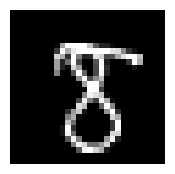

Étiquette : 8


In [22]:
# L'image à afficher et à tester
i = 108

# Afficher l'image
plt.figure(figsize=(2, 2))
plt.axis('off')
plt.imshow(images_plot[i-1], cmap="gray", aspect='auto')
plt.show()

# Afficher le label correct pour l'image
print("Étiquette : {}".format(labels_test[i-1]))


1/1 [==============================] - 0s 140ms/step


<BarContainer object of 10 artists>

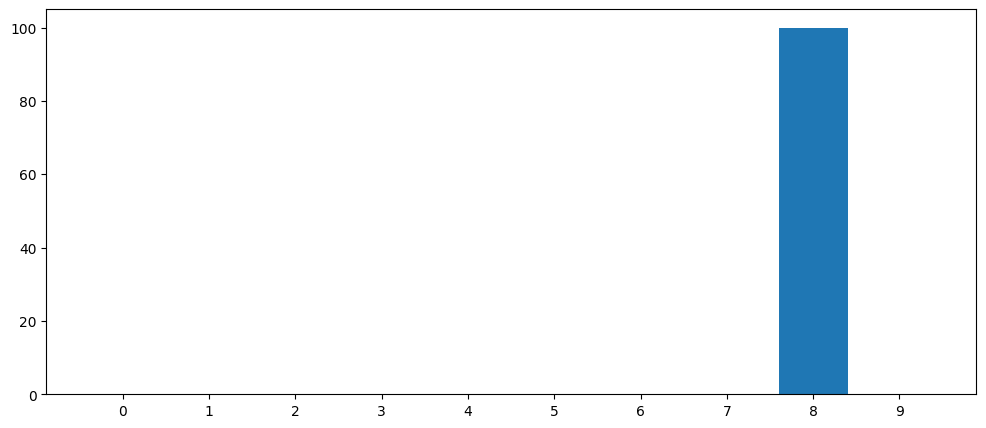

In [23]:
# Obtenir les prédictions (logits) du modèle
predictions = model.predict(images_test[i-1:i])

# Convertir ces prédictions en probabilités (rappelons-nous que nous avons intégré l'activation softmax dans la fonction de perte)
probabilities = tf.nn.softmax(predictions).numpy()
# Convertir les probabilités en pourcentages
probabilities = probabilities*100

# Créer un graphique à barres pour afficher les probabilités pour chaque classe
plt.figure(figsize=(12,5))
plt.bar(x=[1,2,3,4,5,6,7,8,9,10], height=probabilities[0], tick_label=["0","1","2","3","4","5","6","7","8","9"])